# Exploring lightning prediction setup

This notebook gets a set of grids and plots them to make sure we are pulling out training data correctly.
Read the [design doc](https://docs.google.com/document/d/1wmJN6G2f74aOZrqm2FJEkoeIQ_bvPz58FdAZr5SqSOk/edit) for more details.

In [ ]:
%%bash
source activate py2env
conda install -y pytz
pip uninstall -y google-cloud-dataflow
pip install --upgrade retrying snappy pyresample netcdf4  google-cloud-storage apache-beam[gcp]

After doing the pip install, Reset Session before continuing.

## Try out the local module

Make sure the local module works. This might take a couple of minutes.

In [ ]:
%bash
source activate py2env
python -m ltgpred.goesutil.goesio

## Read Infrared data

In [5]:
from __future__ import print_function
from __future__ import division
import ltgpred.goesutil.goesio as goesio
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [6]:
latlonres = 0.02
griddef = goesio.create_conus_griddef(latlonres)
irblob = goesio.get_ir_blob_paths(2018, 134, 20)[0] # top of the hour
ref = goesio.read_ir_data(irblob, griddef)

0.0


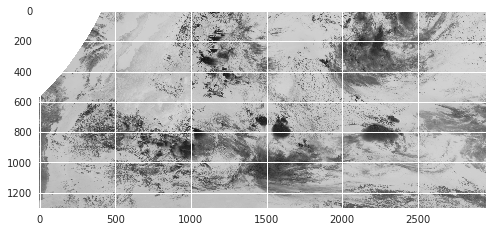

In [14]:
plt.imshow(ref);
print(ref[0,0])

## Read lightning data
Lightning data is actually just event observations every 20s. So we have to accumulate in a grid

In [8]:
# lightning blobs for 15 minutes as of the IR image
influence_km = 5
irdt = goesio.get_timestamp_from_filename(irblob)
ltg_blobs = goesio.get_ltg_blob_paths(irdt, timespan_minutes=15)
ltg = goesio.create_ltg_grid(ltg_blobs, griddef, influence_km)

8532 events; 8241 events; 7315 events; 9817 events; 8037 events; 10357 events; 7942 events; 7240 events; 7368 events; 7787 events; 8751 events; 7808 events; 8049 events; 8902 events; 8255 events; 8144 events; 9313 events; 7831 events; 8287 events; 6626 events; 7589 events; 10498 events; 7299 events; 6696 events; 8075 events; 9245 events; 9454 events; 7178 events; 7831 events; 7277 events; 8351 events; 8145 events; 7912 events; 9594 events; 8015 events; 7386 events; 7420 events; 7463 events; 6996 events; 7671 events; 8016 events; 8551 events; 8440 events; 7117 events; 9324 events; 

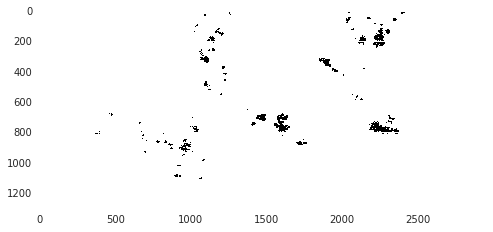

In [9]:
plt.imshow(ltg);

## Relationship between IR and lightning

Mean lightning as the reflectivity threshold is increased

In [11]:
def print_stats(name, data):
  print('{}: shape={}, mean={}, min={}, max={} count={}'.format(name, data.shape, np.mean(data), np.min(data), np.max(data), np.sum(~np.isnan(data))))

print_stats('ref', ref)
print_stats('ltg for all pixels', ltg)
print_stats('ref for ltg pixels', ref[ltg > 0.5])

ref: shape=(1300, 2950), mean=0.429475933313, min=0.0, max=1.0 count=3835000
ltg for all pixels: shape=(1300, 2950), mean=0.0124146023468, min=0.0, max=1.0 count=3835000
ref for ltg pixels: shape=(47610,), mean=0.721737682819, min=0.261066615582, max=1.0 count=47610


The average reflectivity associated with all pixels is 0.43 while the reflectivity associated with lightning pixels is 0.72.

In [9]:
for thresh in np.arange(0, 1, 0.1):
  print_stats('ltg where ref > {}'.format(thresh), ltg[ref > thresh])

ltg where ref > 0.0: shape=(3701795,), mean=0.0128613280854, min=0.0, max=1.0
ltg where ref > 0.1: shape=(3701795,), mean=0.0128613280854, min=0.0, max=1.0
ltg where ref > 0.2: shape=(3701795,), mean=0.0128613280854, min=0.0, max=1.0
ltg where ref > 0.3: shape=(3438062,), mean=0.0138153413173, min=0.0, max=1.0
ltg where ref > 0.4: shape=(1704052,), mean=0.0257891191114, min=0.0, max=1.0
ltg where ref > 0.5: shape=(1070853,), mean=0.0378856855236, min=0.0, max=1.0
ltg where ref > 0.6: shape=(642723,), mean=0.0571412568089, min=0.0, max=1.0
ltg where ref > 0.7: shape=(295438,), mean=0.106563813727, min=0.0, max=1.0
ltg where ref > 0.8: shape=(88084,), mean=0.261625266791, min=0.0, max=1.0
ltg where ref > 0.9: shape=(3196,), mean=0.572903629537, min=0.0, max=1.0


In [10]:
print(griddef.lats)

[[24.   24.   24.   ... 24.   24.   24.  ]
 [24.02 24.02 24.02 ... 24.02 24.02 24.02]
 [24.04 24.04 24.04 ... 24.04 24.04 24.04]
 ...
 [49.94 49.94 49.94 ... 49.94 49.94 49.94]
 [49.96 49.96 49.96 ... 49.96 49.96 49.96]
 [49.98 49.98 49.98 ... 49.98 49.98 49.98]]


Once we get to a reflectivity threshold of 0.9, then 57% of the pixels are associated with lightning.

## Create training examples from IR and lightning

See if there is signal by doing a bit of feature engineering on the ref array and then using scikit-learn

In [11]:
N = 32
strideN = N
halfN = N//2
N15 = N + halfN

def get_prediction_grid_centers(ref): 
  cy, cx = np.meshgrid(np.arange(N15, ref.shape[0]-N15, strideN),
                       np.arange(N15, ref.shape[1]-N15, strideN))
  cy = cy.ravel()
  cx = cx.ravel()
  return zip(cy, cx)

def rawdata_input_fn(ref, ltg, griddef):
  for cy, cx in get_prediction_grid_centers(ref):
    # restrict to grids where there is lightning in the area
    interesting = np.sum(ltg[cy-N15:cy+N15, cx-N15:cx+N15]) > 0.5
    if interesting:
      label = np.sum(ltg[cy-halfN:cy+halfN, cx-halfN:cx+halfN]) > 0.5
      example = {
          'lon': griddef.lons[cy][cx],
          'lat': griddef.lats[cy][cx], 
          'ref_smallbox': ref[cy-halfN:cy+halfN, cx-halfN:cx+halfN],
          'ref_bigbox': ref[cy-N15:cy+N15, cx-N15:cx+N15],
          'has_ltg': label #1.0 if label else 0.0
      }
      yield example

def create_prediction_df(ref, ltg, griddef):
  data = []
  for example in rawdata_input_fn(ref, ltg, griddef):
    data.append([example['lat'],
                 example['lon'],
                 np.mean(example['ref_smallbox']), # mean within subgrid
                 np.max(example['ref_smallbox']),
                 np.mean(example['ref_bigbox']),
                 np.max(example['ref_bigbox']),
                 example['has_ltg']
                ])

  import pandas as pd
  df = pd.DataFrame(data, columns=['lat', 'lon', 'meanref_smallbox', 'maxref_smallbox', 'meanref_bigbox', 'maxref_bigbox', 'ltg'])
  print('For lightning grids {}'.format(df[df['ltg']].describe()))
  print('For no-lightning grids {}'.format(df[~df['ltg']].describe()))
  return df

In [13]:
from sklearn.linear_model import LinearRegression, LogisticRegression
model = LogisticRegression()
df = create_prediction_df(ref, ltg, griddef)
x = df.drop(['lat', 'lon', 'ltg'], axis=1)
model = model.fit(x, df['ltg'] > 0.5)
print(model.coef_, model.intercept_)
print('Model accuracy={}%'.format(100*model.score(x, df['ltg'])))

For lightning grids               lat         lon  meanref_smallbox  maxref_smallbox  \
count  226.000000  226.000000        226.000000       226.000000   
mean    35.514336  -94.979469          0.613720         0.881932   
std      6.086618   11.740588          0.138548         0.059697   
min     24.960000 -117.640000          0.332404         0.609629   
25%     29.440000 -104.840000          0.498058         0.854879   
50%     37.760000  -96.840000          0.614175         0.886846   
75%     40.320000  -82.440000          0.720277         0.918329   
max     46.080000  -77.320000          0.872843         1.000000   

       meanref_bigbox  maxref_bigbox  
count      226.000000     226.000000  
mean         0.582153       0.933181  
std          0.100319       0.033514  
min          0.375210       0.851328  
25%          0.506832       0.909649  
50%          0.577194       0.933441  
75%          0.646450       0.956641  
max          0.811117       1.000000  
For no-lightning

We can detect lightning reasonably well based on just the IR temperature.

## Predicting lightning

How about if we try to predict lightning 30 minutes into the future?

In [14]:
from datetime import timedelta

ltg30_blobs = goesio.get_ltg_blobs(irdt + timedelta(minutes=30), timespan_minutes=15)
ltg30 = goesio.create_ltg_grid(ltg30_blobs, griddef, influence_km)

model = LogisticRegression()
df = create_prediction_df(ref, ltg30, griddef)
x = df.drop(['lat', 'lon', 'ltg'], axis=1)
model = model.fit(x, df['ltg'])
print(model.coef_, model.intercept_)
print('Model accuracy={}%'.format(100*model.score(x, df['ltg'])))

10345 events; 9446 events; 9458 events; 8479 events; 9717 events; 8823 events; 7679 events; 9065 events; 8821 events; 9369 events; 8834 events; 12393 events; 9143 events; 9278 events; 8489 events; 8973 events; 9076 events; 9914 events; 10227 events; 9171 events; 9749 events; 10301 events; 9100 events; 9439 events; 8953 events; 8891 events; 8765 events; 9525 events; 12106 events; 10295 events; 10581 events; 9694 events; 11359 events; 8908 events; 8676 events; 9375 events; 9727 events; 10896 events; 12553 events; 11331 events; 15492 events; 10813 events; 10368 events; 13694 events; 10158 events; For lightning grids               lat         lon  meanref_smallbox  maxref_smallbox  \
count  256.000000  256.000000        256.000000       256.000000   
mean    35.592500  -95.087500          0.604469         0.874023   
std      6.137973   11.225693          0.139141         0.064274   
min     24.960000 -116.360000          0.332404         0.588439   
25%     30.080000 -104.200000          

Not bad at all!  We got accuracy of 74% predicting lightning 30 minutes into the future. Of course, this is training & validation on the same hour of data.

## Visualize the prediction

The prediction grid has a resolution that is N times coarser than the original because we were predicting only at the centers (we could always do it at a finer resolution though, by reducing strideN).

In [ ]:
df['predicted'] = model.predict_proba(x)
df.head()

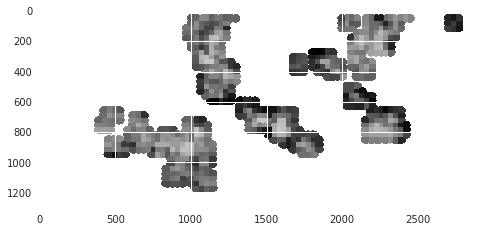

In [40]:
import pyresample as pr
swath_def = pr.geometry.SwathDefinition(lats=df['lat'], lons=df['lon'])
ltgpred = pr.kd_tree.resample_nearest(swath_def, df['predicted'].values, griddef, radius_of_influence=1000*latlonres*100*N, epsilon=0.5)
plt.imshow(ltgpred);

## Beam pipeline to create training dataset

The above was on just one hour of data.  Here's the start of a Beam pipeline that will generate a list of training and evaluation dataset hours. 

In [17]:
import apache_beam as beam
import shutil
import os

def generate_hours(starthour, endhour, startday, endday, startyear, endyear, is_train):
  for h in xrange(starthour, endhour+1):
    for d in xrange(startday, endday+1):
      for y in xrange(startyear, endyear+1):
        data = {
          'hour': h,
          'day': d,
          'year': y
        }
        if hash(str(data)) % 10 < 7:
          if is_train:
            yield data
        else:
          if not is_train:
            yield data

OUTPUT_DIR = './preproc'
RUNNER = 'DirectRunner'
options = {
      'staging_location': os.path.join(OUTPUT_DIR, 'tmp', 'staging'),
      'temp_location': os.path.join(OUTPUT_DIR, 'tmp'),
      'job_name': 'hello',
      'project': 'cloud-training-demos',
      'teardown_policy': 'TEARDOWN_ALWAYS',
      'no_save_main_session': True
}
opts = beam.pipeline.PipelineOptions(flags = [], **options)
shutil.rmtree(OUTPUT_DIR, ignore_errors=True)
p = beam.Pipeline(RUNNER, options=opts)

for step in ['train', 'eval']:
  (p 
   | '{}_hours'.format(step) >> beam.Create(generate_hours(12, 14, 183, 184, 2018, 2018, step == 'train'))
   | '{}_write'.format(step) >> beam.io.Write(beam.io.WriteToText(os.path.join(OUTPUT_DIR, step)))
  )

job = p.run()
job.wait_until_finish()

'DONE'

/usr/local/envs/py2env/lib/python2.7/site-packages/simplejson/encoder.py:296: DeprecationWarning: Interpreting naive datetime as local 2018-08-10 18:16:52.084321. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [18]:
!head preproc/*

==> preproc/eval-00000-of-00001 <==
{'day': 184, 'hour': 13, 'year': 2018}
{'day': 184, 'hour': 14, 'year': 2018}

==> preproc/train-00000-of-00001 <==
{'day': 183, 'hour': 12, 'year': 2018}
{'day': 184, 'hour': 12, 'year': 2018}
{'day': 183, 'hour': 13, 'year': 2018}
{'day': 183, 'hour': 14, 'year': 2018}


/usr/local/envs/py2env/lib/python2.7/site-packages/simplejson/encoder.py:296: DeprecationWarning: Interpreting naive datetime as local 2018-08-10 18:16:57.795276. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


Let's invoke the above functions, and put it into our Python module.

In [ ]:
%bash
source activate py2env
python -m ltgpred.create_dataset \
   --outdir=./preproc \
   --startday 183 --endday 183  --starthour 13  --endhour 13 --lightning_validity 2

Now, turn it loose to process 100x24 hours of data:

In [ ]:
%bash
source activate py2env
PROJECT='cloud-training-demos'
BUCKET='cloud-training-demos-ml'
python -m ltgpred.create_dataset \
   --outdir=gs://$BUCKET/lightning/preproc \
   --startday 100 --endday 150 --project=$PROJECT

In [6]:
import apache_beam as beam
import datetime
[1, 2, 3] | beam.Map(lambda x : datetime.datetime(2018,x,1)) | beam.

[datetime.datetime(2018, 1, 1, 0, 0),
 datetime.datetime(2018, 2, 1, 0, 0),
 datetime.datetime(2018, 3, 1, 0, 0)]

## Next steps

* Instead of using just 4 features of the IR grid (mean, max of two rectangular subgrids), use all the pixels
* Train models

Copyright 2017 Google Inc. Licensed under the Apache License, Version 2.0 (the \"License\"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an \"AS IS\" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License